In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torchvision.models import vgg16, VGG16_Weights
from torchvision.io import read_image
from torchvision.transforms import Resize

x = torch.rand(size=(1, 3, 224, 224))
model = vgg16(weights=VGG16_Weights.DEFAULT)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [4]:
model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
import matplotlib.pyplot as plt
import torch


def plot_relevance_scores(
    x: torch.tensor, r: torch.tensor, name: str
) -> None:
    """Plots results from layer-wise relevance propagation next to original image.

    Method currently accepts only a batch size of one.

    Args:
        x: Original image.
        r: Relevance scores for original image.
        name: Image name.
        config: Argparse namespace object.

    """

    max_fig_size = 20

    _, _, img_height, img_width = x.shape
    max_dim = max(img_height, img_width)
    fig_height, fig_width = (
        max_fig_size * img_height / max_dim,
        max_fig_size * img_width / max_dim,
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, fig_height))

    x = x[0].squeeze().permute(1, 2, 0).detach().cpu()
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    axes[0].imshow(x)
    axes[0].set_axis_off()

    r = r[0].sum(dim=0).cpu()
    r_min = r.min()
    r_max = r.max()
    r = (r - r_min) / (r_max - r_min)
    axes[1].imshow(r, cmap="afmhot")
    axes[1].set_axis_off()

    fig.tight_layout()

In [6]:
# resize_transform = Resize((224,224))
# img = resize_transform(read_image("cat_1.jpg").float()).unsqueeze(0)
img = read_image("../../external/PyTorchRelevancePropagation/input/cats/cat_1.jpg").float().unsqueeze(0)

In [7]:
img = img.to(device)
img.requires_grad_(True)
output = model(img)

In [8]:
from lrp_engine import LRPEngine

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
starting_relevance = torch.zeros_like(output)
starting_relevance[:,281:286] = 1.0 # Assigning start relevance to classes involving cats, see last cell for method

In [10]:
lrp_engine = LRPEngine(params_to_interpret = [ img ], use_z_plus=True, relevance_filter=0.1, starting_relevance=starting_relevance)

In [11]:
# Warmup iteration
lrp_output = lrp_engine.run(output)

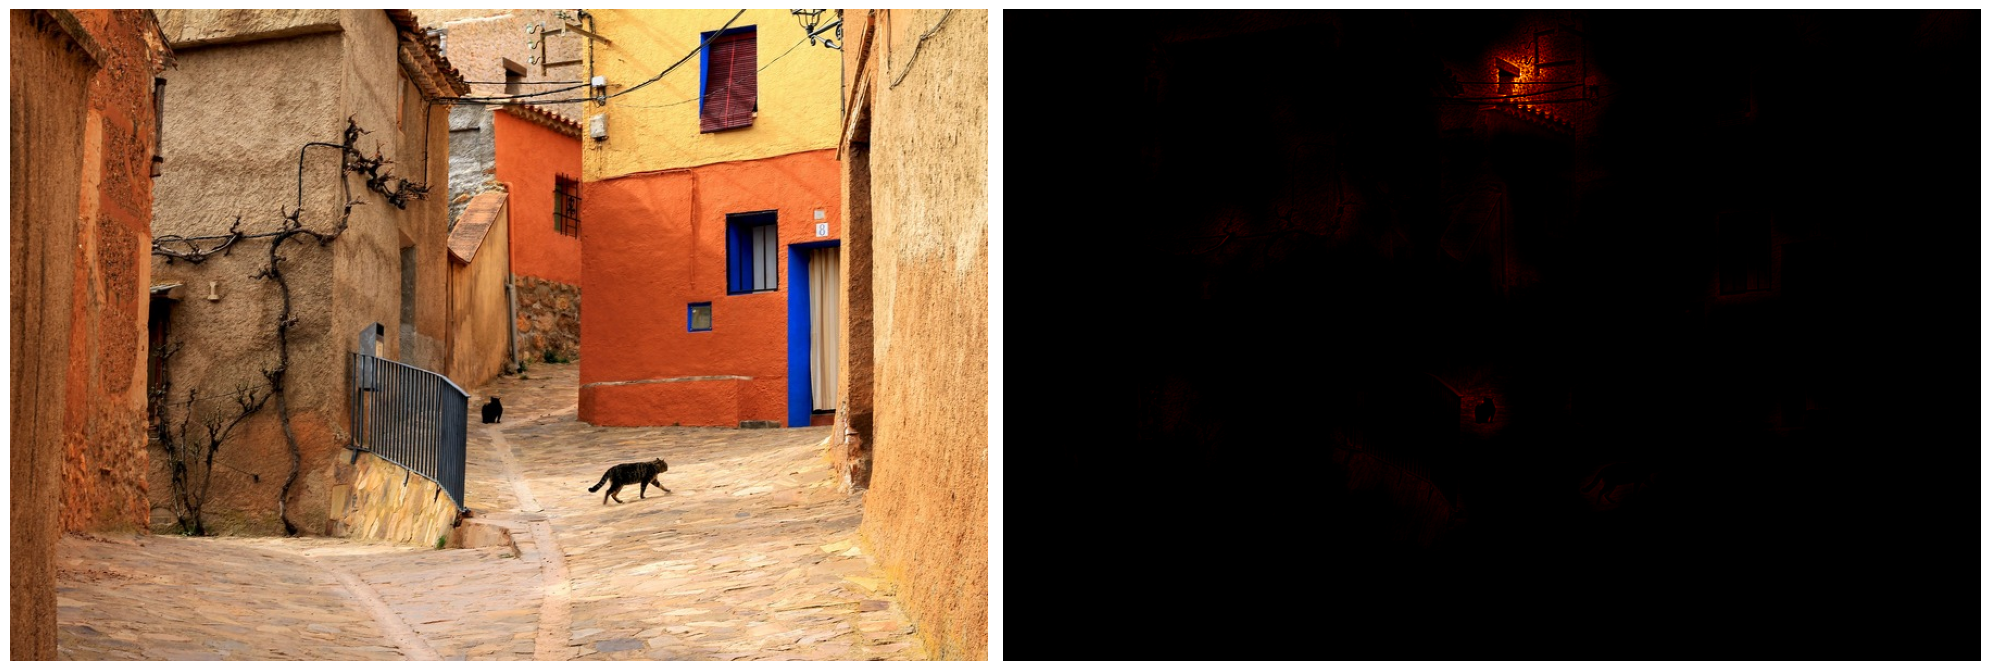

In [14]:
# REALLY WEIRD: CPU AND CUDA PRODUCE DIFFERENT RESULTS, BUT THIS DOES NOT APPEAR IN OTHER MODEL TESTS!!
plot_relevance_scores(img, lrp_output[1][0].nan_to_num(), "cat_1")

In [11]:
import time
import random
rel_maps = []
imgs = [ read_image(f"../../external/PyTorchRelevancePropagation/input/cats/cat_{i}.jpg").float().unsqueeze(0) for i in range(1, 9) ]
for img in imgs:
    img = img.to(device)
    img.requires_grad_(True)
    t0 = time.time()
    output = model(img)
    lrp_output = lrp_engine.run(output)
    rel_maps.append(lrp_output[1][0].nan_to_num())
    print("{time:.2f} FPS".format(time=(1.0 / (time.time() - t0))))


15.49 FPS
15.87 FPS
17.24 FPS
18.87 FPS
15.87 FPS
11.36 FPS
23.81 FPS
21.74 FPS


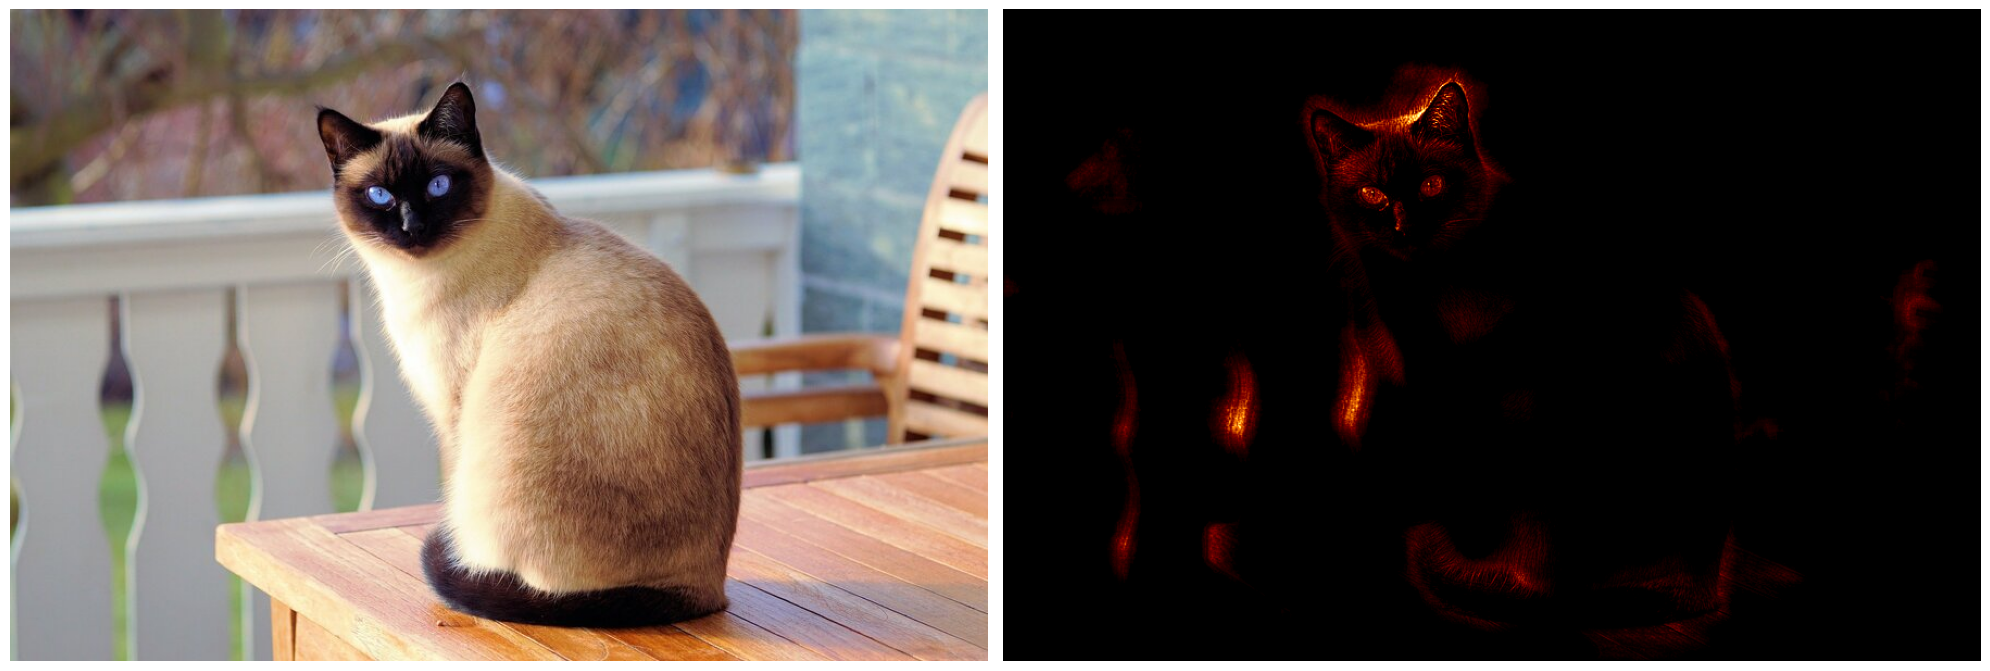

In [13]:
img_ind = 2
plot_relevance_scores(imgs[img_ind], rel_maps[img_ind], f"cat_{img_ind + 1}")

Our LRP ran at peak 1.11GB RAM and 6.5GB VRAM for the 8 examples.

For reference, here are the speeds of the original implementation:\
3.41 FPS\
9.17 FPS\
9.80 FPS\
9.62 FPS\
9.52 FPS\
9.62 FPS\
20.83 FPS\
20.41 FPS

Theirs ran at peak 1.2GB RAM and 4GB VRAM for the 8 examples.\
In addition, through shuffling we can see the speeds are clearly shown to be correlated to the image itself.

e.g.

Run 1:\
20.41 FPS <--\
21.28 FPS <--\
9.43 FPS\
9.78 FPS\
9.78 FPS\
9.71 FPS\
9.71 FPS\
9.80 FPS

Run 2:\
9.23 FPS\
9.80 FPS\
22.21 FPS <--\
9.71 FPS\
9.80 FPS\
21.73 FPS <--\
9.71 FPS\
7.25 FPS

Run 3:\
8.20 FPS\
21.67 FPS <--\
9.80 FPS\
21.74 FPS <--\
9.35 FPS\
8.55 FPS\
9.71 FPS\
9.71 FPS\

In [41]:
# Now, try shuffling on ours
# Also experiment with adding a pause between batches, seeing the effect of temporal cache locality
import time
import random
for pause in range(2):
    if pause:
        print("Running with 3 second pause between each batch...")
    else:
        print("Running with no pause between each batch...")
    for run_idx in range(3):
        print(f"Run {run_idx}:")
        imgs = [ (i, read_image(f"../../PyTorchRelevancePropagation/input/cats/cat_{i}.jpg").float().unsqueeze(0)) for i in range(1, 9) ]
        random.shuffle(imgs)
        for idx, img in imgs:
            img = img.to(device)
            img.requires_grad_(True)
            t0 = time.time()
            output = model(img)
            lrp_output = lrp_engine.run(output)
            print(f"{(1.0 / (time.time() - t0)):.2f} FPS img {idx}")
        print("")
        if pause:
            time.sleep(3)
    time.sleep(3)

Running with no pause between each batch...
Run 0:
3.46 FPS img 3
17.86 FPS img 5
17.86 FPS img 2
16.95 FPS img 6
26.32 FPS img 8
18.52 FPS img 1
27.03 FPS img 7
17.54 FPS img 4

Run 1:
18.18 FPS img 3
16.67 FPS img 1
22.22 FPS img 7
15.26 FPS img 4
19.23 FPS img 8
17.86 FPS img 5
15.38 FPS img 2
16.39 FPS img 6

Run 2:
22.73 FPS img 7
16.39 FPS img 5
15.87 FPS img 3
15.15 FPS img 6
19.61 FPS img 8
18.18 FPS img 2
17.54 FPS img 4
17.86 FPS img 1

Running with 3 second pause between each batch...
Run 0:
4.35 FPS img 5
25.64 FPS img 8
17.86 FPS img 2
17.24 FPS img 1
25.00 FPS img 7
16.81 FPS img 3
16.95 FPS img 6
17.24 FPS img 4

Run 1:
3.95 FPS img 6
15.15 FPS img 5
15.38 FPS img 1
15.63 FPS img 4
15.15 FPS img 2
25.64 FPS img 7
23.81 FPS img 8
16.95 FPS img 3

Run 2:
7.80 FPS img 8
14.49 FPS img 6
16.67 FPS img 4
15.38 FPS img 3
17.24 FPS img 5
16.95 FPS img 1
16.10 FPS img 2
22.22 FPS img 7



In [9]:
# How I found which logits to start at the output for "cat"
import json
import urllib.request

# Download ImageNet class index
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_idx = []
with urllib.request.urlopen(url) as f:
    class_idx = [line.decode('utf-8').strip() for line in f]

In [13]:
list(enumerate(class_idx))

[(0, 'tench'),
 (1, 'goldfish'),
 (2, 'great white shark'),
 (3, 'tiger shark'),
 (4, 'hammerhead'),
 (5, 'electric ray'),
 (6, 'stingray'),
 (7, 'cock'),
 (8, 'hen'),
 (9, 'ostrich'),
 (10, 'brambling'),
 (11, 'goldfinch'),
 (12, 'house finch'),
 (13, 'junco'),
 (14, 'indigo bunting'),
 (15, 'robin'),
 (16, 'bulbul'),
 (17, 'jay'),
 (18, 'magpie'),
 (19, 'chickadee'),
 (20, 'water ouzel'),
 (21, 'kite'),
 (22, 'bald eagle'),
 (23, 'vulture'),
 (24, 'great grey owl'),
 (25, 'European fire salamander'),
 (26, 'common newt'),
 (27, 'eft'),
 (28, 'spotted salamander'),
 (29, 'axolotl'),
 (30, 'bullfrog'),
 (31, 'tree frog'),
 (32, 'tailed frog'),
 (33, 'loggerhead'),
 (34, 'leatherback turtle'),
 (35, 'mud turtle'),
 (36, 'terrapin'),
 (37, 'box turtle'),
 (38, 'banded gecko'),
 (39, 'common iguana'),
 (40, 'American chameleon'),
 (41, 'whiptail'),
 (42, 'agama'),
 (43, 'frilled lizard'),
 (44, 'alligator lizard'),
 (45, 'Gila monster'),
 (46, 'green lizard'),
 (47, 'African chameleon'),
